<a href="https://colab.research.google.com/github/Sim98B/TabularDataGeneration/blob/main/BrainTumor/BrainTumorConditionalImageGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Conditional Image Generation

# Index

1. [Libraries](#Libraries)
2. [Data Preparation](#Breast-Cancer-Data)
3. [A stronger model](#Wassesrstein-GAN-with-Gradient-Penalty)
4. [Are the data good enough?](#Data-Evaluation)
5. [Validation Protocol](#TOR-TS-protocol)
6. [Latent Evaluation](#Principal-Component-Analysis)
7. [Conclusion](#Conclusion)

In [3]:
import sys
import os
import shutil

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import skew, kurtosis, iqr

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils

import torchmetrics

import random
from tqdm.auto import tqdm
import joblib

import warnings
warnings.filterwarnings('ignore')

In [4]:
!git clone https://github.com/Sim98B/TabularDataGeneration.git

to_keep_files = ['BrainTumor', 'utils.py', '.git']
base_dir = 'TabularDataGeneration'

for item in os.listdir(base_dir):
    item_path = os.path.join(base_dir, item)

    if item not in to_keep_files:
        if os.path.isfile(item_path):
            os.remove(item_path)
        elif os.path.isdir(item_path):
            import shutil
            shutil.rmtree(item_path)

sys.path.append("TabularDataGeneration")
import utils

Cloning into 'TabularDataGeneration'...
remote: Enumerating objects: 4076, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 4076 (delta 73), reused 49 (delta 34), pack-reused 3968 (from 1)
Receiving objects: 100% (4076/4076), 124.77 MiB | 6.76 MiB/s, done.
Resolving deltas: 100% (504/504), done.


In [27]:
tumor_mapping = {0: 'Clear', 1: 'Glioma', 2: 'Meningioma', 3: 'Pituitary'}
section_mapping = {0: 'Axial', 1: 'Coronal', 2: 'Sagittal'}

class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []  # (tumor_type, section_type)

        tumor_types = sorted(os.listdir(root_dir))
        self.tumor_dict = {tumor: i for i, tumor in enumerate(tumor_types)}

        for tumor in tumor_types:
            tumor_path = os.path.join(root_dir, tumor)
            if not os.path.isdir(tumor_path):
                continue

            section_types = sorted(os.listdir(tumor_path))
            self.section_dict = {section: i for i, section in enumerate(section_types)}

            for section in section_types:
                section_path = os.path.join(tumor_path, section)
                if not os.path.isdir(section_path):
                    continue

                for img_name in os.listdir(section_path):
                    img_path = os.path.join(section_path, img_name)
                    if img_name.endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(img_path)
                        self.labels.append((self.tumor_dict[tumor], self.section_dict[section]))
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        tumor_label, section_label = self.labels[idx]

        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        return image, (tumor_label, section_label)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5], std = [0.5])
])

dataset = BrainTumorDataset(root_dir = "TabularDataGeneration/BrainTumor/Data", transform = transform)
dataloader = DataLoader(dataset, batch_size = 128, shuffle = True, num_workers = 2)

for images, labels in dataloader:
    print(f"Batch: {images.shape}")
    print(f"Tumor Labels: {[tumor_mapping[int(i)] for i in labels[0]]}")
    print(f"Section Label: {[section_mapping[int(i)] for i in labels[1]]}")
    break

Batch: torch.Size([128, 1, 256, 256])
Tumor Labels: ['Glioma', 'Glioma', 'Meningioma', 'Pituitary', 'Glioma', 'Pituitary', 'Meningioma', 'Meningioma', 'Glioma', 'Meningioma', 'Glioma', 'Clear', 'Pituitary', 'Pituitary', 'Clear', 'Glioma', 'Meningioma', 'Meningioma', 'Meningioma', 'Clear', 'Glioma', 'Glioma', 'Pituitary', 'Pituitary', 'Meningioma', 'Clear', 'Glioma', 'Pituitary', 'Clear', 'Glioma', 'Pituitary', 'Glioma', 'Clear', 'Glioma', 'Glioma', 'Glioma', 'Meningioma', 'Glioma', 'Pituitary', 'Pituitary', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Meningioma', 'Glioma', 'Glioma', 'Meningioma', 'Glioma', 'Meningioma', 'Glioma', 'Glioma', 'Pituitary', 'Clear', 'Meningioma', 'Meningioma', 'Glioma', 'Pituitary', 'Clear', 'Clear', 'Meningioma', 'Pituitary', 'Meningioma', 'Glioma', 'Clear', 'Pituitary', 'Meningioma', 'Pituitary', 'Meningioma', 'Pituitary', 'Pituitary', 'Glioma', 'Meningioma', 'Glioma', 'Pituitary', 'Glioma', 'Glioma', 'Glioma', 'Clear', 'Meningioma', 'Meningioma', 

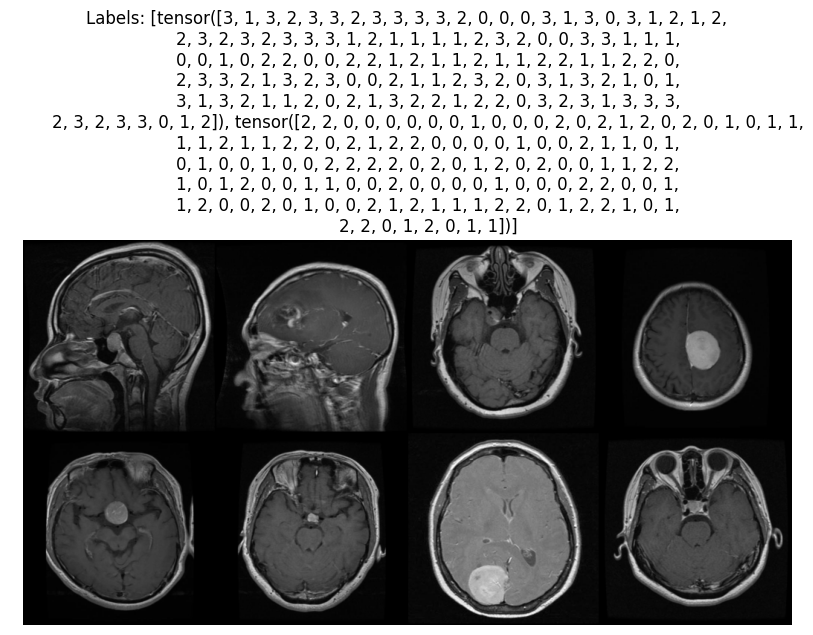

In [28]:
utils.set_seed()

dataiter = iter(dataloader)
images, labels = next(dataiter)

# Visualizza le immagini
def show_images(images, labels, num_images = 8):
    images = images[:num_images]
    grid_img = vutils.make_grid(images, nrow = 4, normalize=True)
    plt.figure(figsize=(10,5))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis("off")
    plt.title(f"Labels: {labels[:num_images]}")
    plt.show()

# Esegui la funzione
show_images(images, labels)